# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.155078,False,2.263294
1,-0.352506,False,-0.217008
2,0.159137,False,-1.648193
3,0.733597,False,1.539087
4,-0.568514,False,0.285338
...,...,...,...
995,0.976307,False,-0.145355
996,-0.113918,True,4.691987
997,-0.197847,False,-0.677530
998,-0.840244,False,-1.782823


<AxesSubplot: xlabel='v0'>

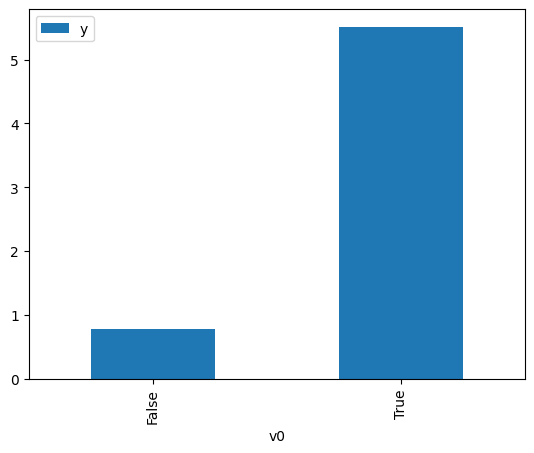

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

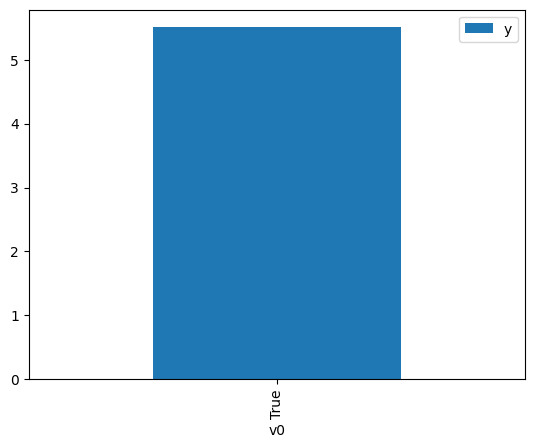

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.689661,False,-0.646117,0.739898,1.351538
1,-0.501458,False,-2.024000,0.681330,1.467718
2,1.615679,False,3.662043,0.079269,12.615247
3,-0.241919,False,-1.774109,0.590518,1.693430
4,2.778920,False,4.951452,0.014525,68.845648
...,...,...,...,...,...
995,1.489933,False,3.287137,0.094359,10.597770
996,-1.980259,False,-3.506359,0.952736,1.049609
997,2.182039,False,3.287019,0.035175,28.429584
998,1.048314,False,1.250732,0.169174,5.911056


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.214838,True,8.232381,0.863438,1.158160
1,0.663175,True,6.947036,0.732460,1.365262
2,0.545580,True,5.202180,0.696084,1.436608
3,1.219538,True,8.559419,0.864277,1.157037
4,-0.832009,True,2.734552,0.220731,4.530407
...,...,...,...,...,...
995,-0.000135,True,4.059453,0.500185,1.999262
996,-0.262943,True,4.971909,0.401792,2.488850
997,0.842902,True,7.436863,0.782421,1.278085
998,-0.881971,True,1.426317,0.207968,4.808435


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          1.268e+04
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                        0.00
Time:                        19:28:20   Log-Likelihood:                         -1404.3
No. Observations:                1000   AIC:                                      2813.
Df Residuals:                     998   BIC:                                      2822.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8301      0.036     51.521      0.000       1.760       1.900
x2             5.0105      0.048    103.463      0.000       4.915       5.106
==============================================================================
Omnibus:                        0.543   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.453
Skew:                          -0.045   Prob(JB):                        0.797
Kurtosis:                       3.052   Cond. No.                         1.91
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""